# testing.ipynb

This notebook loads truth and reco level data from the prepped h5 files, fits the data using the pre-trained keras model of choice, and outputs data similar to what would be found in the KLFitter.

## Imports

In [1]:
import numpy as np
import vector
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py
import os 
from clr_callback import *
from tensorflow.keras.callbacks import TensorBoard
import tensorflow.keras.backend as K  
from tensorflow.keras.optimizers import * 
import glob
import re
import importlib 
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Choosing and Loading Files

In [2]:
# Choose which data type to look at
data_type = 'parton_ejets'
#data_type = 'parton_mjets'

# Choose whether to use the data/model that includes ttbar variables
ttbar_addon = True
addon_tag = '_ttbar_addon' if ttbar_addon else ''

# Numpy array of [max,mean] for each variable
X_maxmean = np.load('X_maxmean_parton_e+mjets'+addon_tag+'_train.npy')  # should always use this same file I think?
Y_maxmean = np.load('Y_maxmean_parton_e+mjets'+addon_tag+'_train.npy')

# Dataset
name = '/data/jchishol/ML_Data/variables_ttbar_'+data_type+addon_tag+'_test.h5'
dataset = h5py.File(name,'r')

# Model
model_name = 'Model_Custom+ttbar' if ttbar_addon else 'Model_Custom'

## Useful Variables

In [3]:
# Number of events in dataset
size = np.array(dataset.get('th_pt')).size
crop0 = size

# X and Y variables to be used
X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_isbtag', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_isbtag', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_isbtag', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_isbtag', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_isbtag', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_isbtag', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
if ttbar_addon == True: Y_keys.extend(('ttbar_pt','ttbar_eta','ttbar_phi','ttbar_m'))
print(Y_keys)

# Variable keys, needed for helper codes
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
isbtag_keys = list(filter(lambda a: 'isbtag' in a, dataset.keys()))

print(crop0)

['th_pt', 'th_eta', 'th_phi', 'th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m', 'ttbar_pt', 'ttbar_eta', 'ttbar_phi', 'ttbar_m']
770325


## Import Helper Codes

In [4]:
import normalize
import shape_timesteps
importlib.reload(normalize)
importlib.reload(shape_timesteps)

# Loss function needed for model fitting (check this with training ... feel like we use it here but not there)
#def loss_fc(true, pred):
#        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))

<module 'shape_timesteps' from '/home/jchishol/TRecNet/shape_timesteps.py'>

## Scale the Data

In [5]:
# Scales data set to be between -1 and 1, with a mean of 0
Scaler = normalize.Scale_variables()
X_total, X_names = Scaler.scale_arrays(X_keys, X_maxmean)
Y_total, Y_names = Scaler.scale_arrays(Y_keys, Y_maxmean)

## Split and Fit Data

In [6]:
# Set how the data will be split (70 for training, 15 for validation, 15 for testing)
#split1 = int(np.floor(0.70*crop0))
#split2 = int(np.floor(0.85*crop0))

# Split into training, validation, and testing data for Y
#trainY, valY, testY = Y_total[0:split1,:], Y_total[split1:split2,:], Y_total[split2:,:]
#print("Training:",trainY.size/Y_total.size)
#print("Validation:",valY.size/Y_total.size)
#print("Testing:",testY.size/Y_total.size)

testY = Y_total

# Split up jets and other for X
timestep_builder = shape_timesteps.Shape_timesteps()
testX_jets, testX_other = timestep_builder.reshape_X(X_total, X_names, False,True)

# Split into training, validation, and testing data for jets and other
#trainX_jets, valX_jets, testX_jets = totalX_jets[0:split1,:,:], totalX_jets[split1:split2,:,:], totalX_jets[split2:,:,:]
#trainX_other, valX_other, testX_other = totalX_other[0:split1,:], totalX_other[split1:split2,:], totalX_other[split2:,:]

In [7]:
# Define bins
other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

# Load machine learning model
#model = keras.models.load_model(model_name+'.keras', custom_objects={'loss_fc':loss_fc})
model = keras.models.load_model(model_name+'.keras')

# Predictions and truth BEFORE they're back to the original scale
predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY

predictions_origscale = Scaler.invscale_arrays(predictions_unscaled, Y_names, Y_maxmean)
true_origscale = Scaler.invscale_arrays(true_unscaled, Y_names, Y_maxmean)



# Using all the data for jets and other, use the model to make predictions
#total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])

# Undo scaling from earlier on both predictions and true data
#predictions_origscale = Scaler.invscale_arrays(total_predictions, Y_names, Y_maxmean)[split:,:]
#true_origscale = Scaler.invscale_arrays(Y_total, Y_names, Y_maxmean)[split:,:]


#dataset.close()

2022-05-30 14:22:40.198493: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-10.1/lib64
2022-05-30 14:22:40.198524: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-30 14:22:40.198859: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [8]:
from observables import norm, cross, dot
from transform import Transform
import uproot

# We're going to turn this into dictionaries for easier reading
#truths = {Y_keys[i] : true_origscale[:,i].reshape((-1,1)) for i in range(len(Y_keys))}
#preds = {Y_keys[i] : predictions_origscale[:,i].reshape((-1,1)) for i in range(len(Y_keys))}
truths = pd.DataFrame(true_origscale,columns=Y_keys)
preds = pd.DataFrame(predictions_origscale,columns=Y_keys)

for var in [truths,preds]:
    
    # Create the 4-vectors for hadronic and leptonic tops
    th_vec = vector.arr({"pt": var['th_pt'], "phi": var['th_phi'], "eta": var['th_eta'],"mass": var['th_m']})
    tl_vec = vector.arr({"pt": var['tl_pt'], "phi": var['tl_phi'], "eta": var['tl_eta'],"mass": var['tl_m']}) 
    
    # Create 4-vector for ttbar (and get ttbar variables if necessary)
    if ttbar_addon:
        ttbar_vec = vector.arr({"pt": var['ttbar_pt'], "phi": var['ttbar_phi'], "eta": var['ttbar_eta'],"mass": var['ttbar_m']})
    else:
        ttbar_vec = th_vec + tl_vec
        var['ttbar_pt'] = ttbar_vec.pt
        var['ttbar_phi'] = ttbar_vec.phi
        var['ttbar_eta'] = ttbar_vec.eta
        var['ttbar_m'] = ttbar_vec.m
    
    # Get vector package to calculate the energies
    var['th_E'] = th_vec.energy
    var['tl_E'] = tl_vec.energy
    var['ttbar_E'] = ttbar_vec.energy
    
    # Get vector package to calculate the rapidities
    var['th_y'] = th_vec.rapidity
    var['tl_y'] = tl_vec.rapidity
    var['ttbar_y'] = ttbar_vec.rapidity
    
    # Calculate pout for th and tl (couldn't use vector for this, so it's a bit messier than I'd like)
    #th_P = np.concatenate([th_vec.px, th_vec.py, th_vec.pz], axis=1)  # concatenates values from the same event into one array
    #tl_P = np.concatenate([tl_vec.px, tl_vec.py, tl_vec.pz], axis=1)
    #ez = np.repeat(np.array([[0,0,1]]), var['th_eta'].shape[0],axis=0)   # Creates list full of vector (0,0,1) with length equal to the number of datapoints
    #var['th_pout'] = dot(th_P, cross(tl_P,ez)/norm(cross(tl_P,ez)))
    #var['tl_pout'] = dot(tl_P, cross(th_P,ez)/norm(cross(tl_P,ez)))
    var['th_pout'] = (th_vec.px*tl_vec.py - th_vec.py*tl_vec.px)/np.sqrt(tl_vec.py**2 + tl_vec.px**2)
    var['tl_pout'] = (tl_vec.px*th_vec.py - tl_vec.py*th_vec.px)/np.sqrt(th_vec.py**2 + th_vec.px**2)
    
    # Calculate some other ttbar variables
    var['ttbar_dphi'] = np.abs(var['th_phi']-var['tl_phi'])
    var['ttbar_Ht'] = var['th_pt']+var['tl_pt']
    var['ttbar_yboost'] = 0.5*(var['th_y']+var['tl_y'])
    var['ttbar_ystar'] = 0.5*(var['th_y']-var['tl_y'])
    var['ttbar_chi'] = np.exp(2*np.abs(var['ttbar_ystar']))
    
    
    # Calculate momentum components (for later calculations)
    #th_px, th_py, th_pz = Transform.polar_to_cart(var['th_pt'],var['th_eta'],var['th_phi'])
    #tl_px, tl_py, tl_pz = Transform.polar_to_cart(var['tl_pt'],var['tl_eta'],var['tl_phi'])
    
    # Calculate total momentums of the had and lep tops
    #th_p = np.sqrt(th_px**2 + th_py**2 + th_pz**2) 
    #tl_p = np.sqrt(tl_px**2 + tl_py**2 + tl_pz**2)
    
    # Calculate had and lep momenum vectors
    #th_P = np.concatenate([th_px, th_py, th_pz], axis=1)  # concatenates values from the same event into one array
    #tl_P = np.concatenate([tl_px, tl_py, tl_pz], axis=1)
    
    # Calculate momenum vector of ttbar?
    #top_P = th_P + tl_P
    #top_px = th_px + tl_px
    #top_py = th_py + tl_py
    #top_pz = th_pz + tl_pz
    
    # Calculate energies of had and lep top
    #th_E, tl_E = np.sqrt(var['th_m']**2+th_p**2), np.sqrt(var['tl_m']**2 + th_p**2)
    
    # Calculate energy of ttbar? and put into dict
    #top_E = th_E + tl_E
    #var['ttbar_E'] = top_E
    
    # Calculate had and lep pout and put into dict
    #ez = np.repeat(np.array([[0,0,1]]), var['th_eta'].shape[0],axis=0)   # Creates list full of vector (0,0,1) with length equal to the number of datapoints
    #var['th_pout'] = dot(th_P, cross(tl_P,ez)/norm(cross(tl_P,ez)))
    #var['tl_pout'] = dot(tl_P, cross(th_P,ez)/norm(cross(tl_P,ez)))

    # Calculate ttbar_Ht and put into dict
    #var['ttbar_Ht'] = var['th_pt']+var['tl_pt']
    
    # Put had and lep energies into the dict
    #var['th_E'] = th_E
    #var['tl_E'] = tl_E
    
    # Calculate ttbar_dphi and put into the dict
    #var['ttbar_dphi'] = np.abs(var['th_phi']-var['tl_phi'])
    
    # Calculate ttbar_m and put into the dict (not 100% about the square root)
    #var['ttbar_m'] = np.sqrt(top_E**2 - norm(top_P)**2) # This is wrong!!
    
    
    # Calculate had and lep y (this is Jenna's attempt, using eq from wikipedia) (could also try using vector)
    #var['th_y'] = np.log((np.sqrt(var['th_m']**2+var['th_pt']**2*np.cosh(var['th_eta'])**2)+var['th_pt']*np.sinh(var['th_eta']))/np.sqrt(var['th_m']**2+var['th_pt']**2))
    #var['tl_y'] = np.log((np.sqrt(var['tl_m']**2+var['tl_pt']**2*np.cosh(var['tl_eta'])**2)+var['tl_pt']*np.sinh(var['tl_eta']))/np.sqrt(var['tl_m']**2+var['tl_pt']**2))
    
    
    # Calculate ttbar_yboost and y*
    #var['ttbar_yboost'] = 0.5*(var['th_y']+var['tl_y'])
    #var['ttbar_ystar'] = 0.5*(var['th_y']-var['tl_y'])
    
    # Calculate eta and phi for ttabr
    #top_pt, top_eta, top_phi = Transform.cart_to_polar(top_P[:,0],top_P[:,1],top_P[:,2])
    #top_pt, top_eta, top_phi = Transform.cart_to_polar(top_px,top_py,top_pz)
    #var['ttbar_pt'] = top_pt
    #var['ttbar_eta'] = top_eta
    #var['ttbar_phi'] = top_phi

    # Calculate ttbar y (this is Jenna's attempt, using eq from wikipedia) (could also try using vector)
    #var['ttbar_y'] = np.log((np.sqrt(var['ttbar_m']**2+var['ttbar_pt']**2*np.cosh(var['ttbar_eta'])**2)+var['ttbar_pt']*np.sinh(var['ttbar_eta']))/np.sqrt(var['ttbar_m']**2+var['ttbar_pt']**2))
    
# Save as a tree root file
final_keys = list(preds.keys())
results_file = uproot.recreate('/data/jchishol/ML_Data/ML_Results_'+data_type+'_'+model_name+'.root')
results_file["reco"] = {final_keys[i]:preds[final_keys[i]] for i in range(len(final_keys))}
results_file["parton"] = {final_keys[i]:truths[final_keys[i]] for i in range(len(final_keys))}

## Plot Truth vs Predictions

/tmp/ipykernel_3284917/2414731915.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(col)


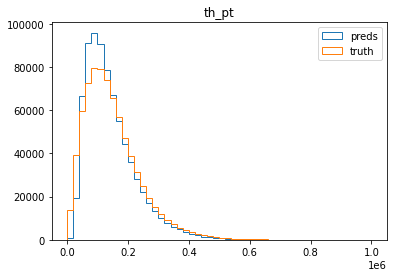

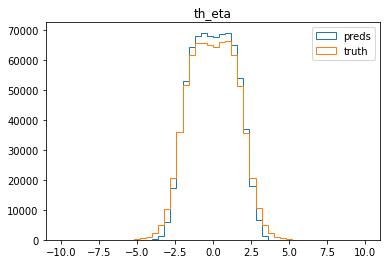

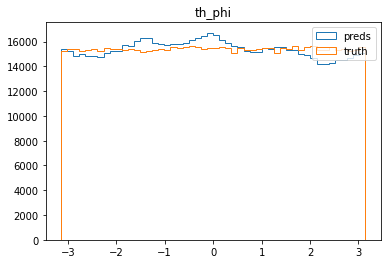

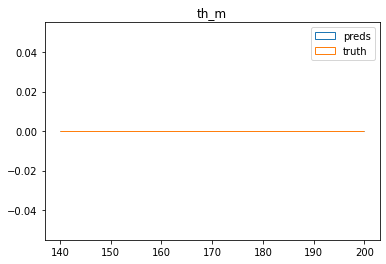

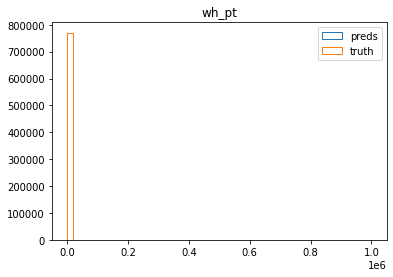

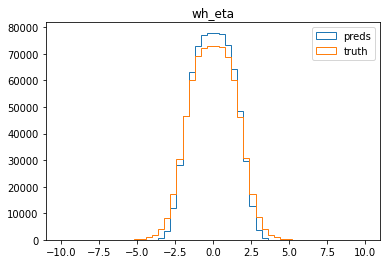

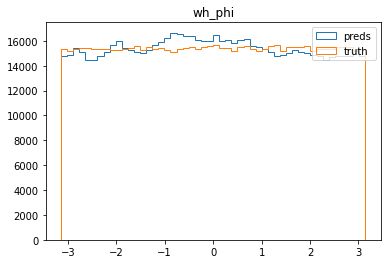

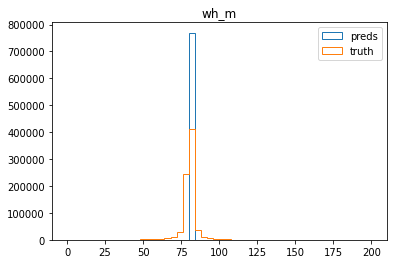

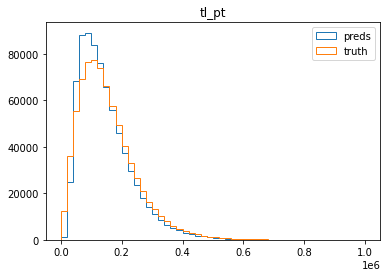

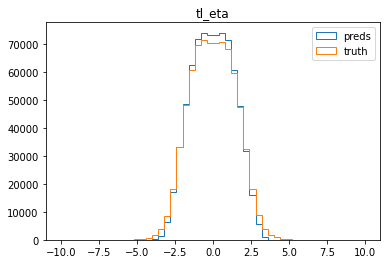

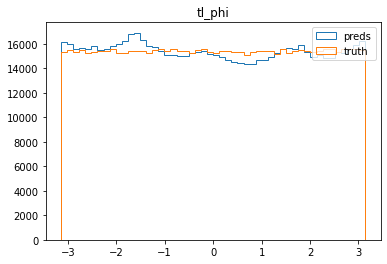

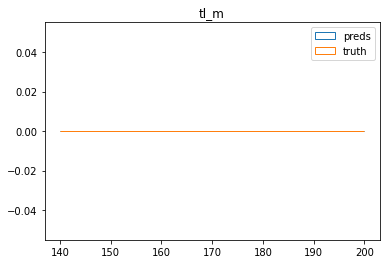

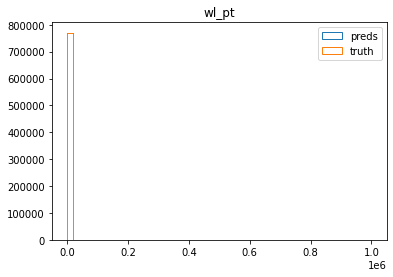

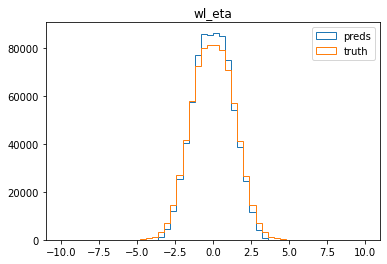

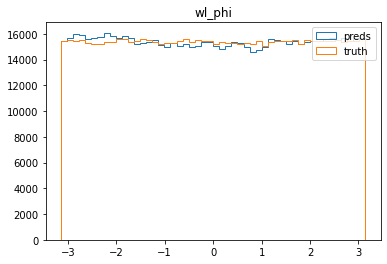

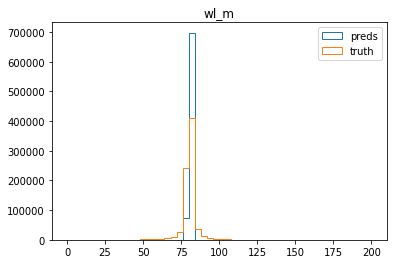

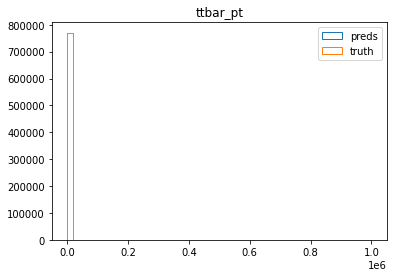

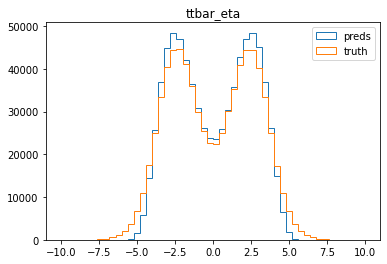

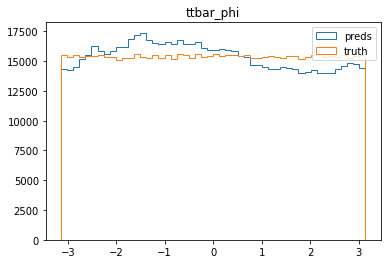

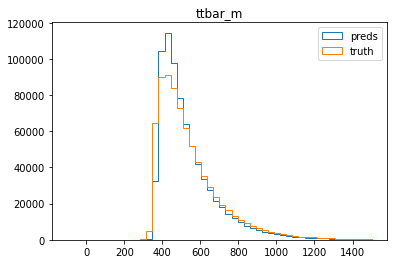

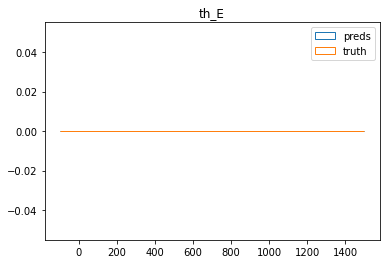

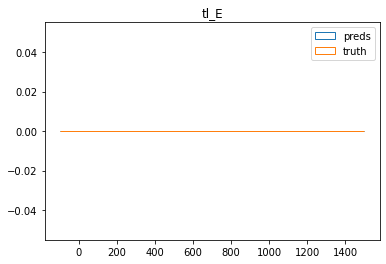

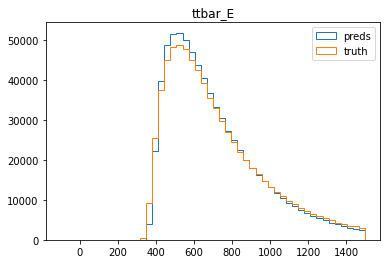

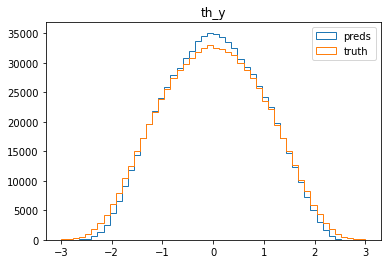

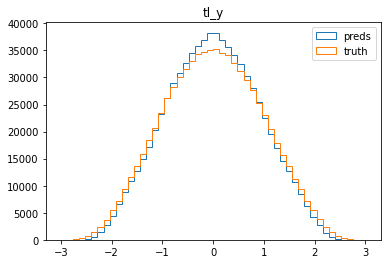

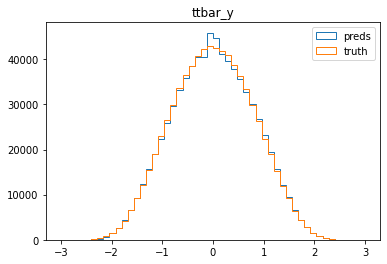

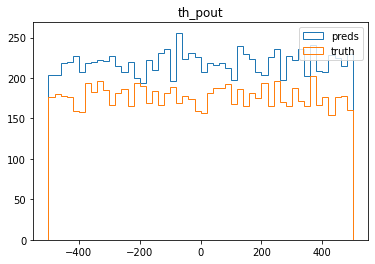

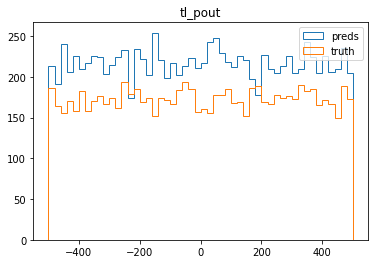

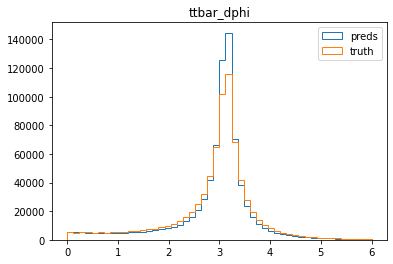

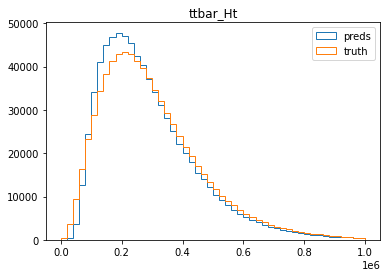

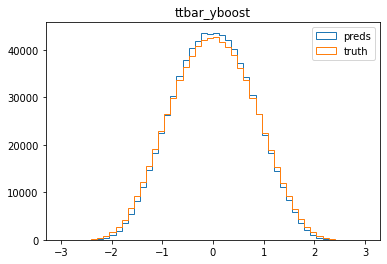

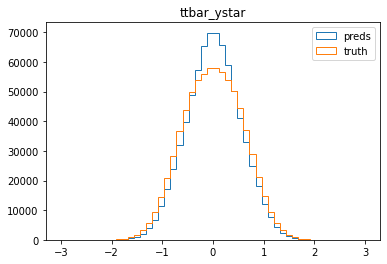

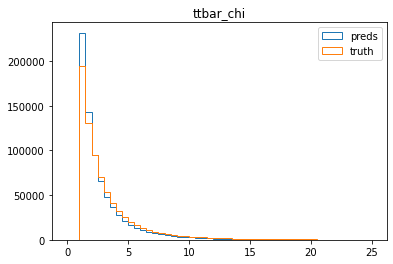

In [17]:
#Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
for col in final_keys:
    
    if col in ['th_pt','tl_pt','wh_pt','wl_pt','ttbar_pt','ttbar_Ht']:
        r = (-100,1000)
    elif col in ['th_E','tl_E','ttbar_E','ttbar_m']:
        r = (-100,1500)
    elif col in ['th_eta','tl_eta','wh_eta','wl_eta','ttbar_eta']:
        r = (-10,10)
    elif col in ['th_phi','tl_phi','wh_phi','wl_phi','ttbar_phi']:
        r = (-3.14,3.14)
    elif col in ['th_pout','tl_pout','ttbar_pout']:
        r = (-500,500)
    elif col in ['th_m','tl_m']:
        r = (140,200)
    elif col in ['wh_m','wl_m']:
        r = (0,200)
    elif col in ['ttbar_m']:
        r = (0,1500)
    elif col in ['th_y','tl_y','ttbar_yboost','ttbar_ystar','ttbar_y']:
        r = (-3,3)
    elif col in ['ttbar_dphi']:
        r = (0,6)
    elif col in ['ttbar_chi']:
        r = (0,25)
    else:
        r = (0,7)

    
    # Create
    plt.figure(col)
    
    # Plot new data
    plt.title(col)
    plt.hist(preds[col],bins=50,range=r,histtype='step')
    plt.hist(truths[col],bins=50,range=r,histtype='step')
    plt.legend(['preds','truth'])


(array([4.67980e+05, 2.54936e+05, 4.04090e+04, 5.85600e+03, 9.59000e+02,
        1.41000e+02, 3.20000e+01, 6.00000e+00, 4.00000e+00, 2.00000e+00]),
 array([2.2256114e+02, 1.5493586e+05, 3.0964916e+05, 4.6436244e+05,
        6.1907575e+05, 7.7378900e+05, 9.2850231e+05, 1.0832156e+06,
        1.2379289e+06, 1.3926422e+06, 1.5473555e+06], dtype=float32),
 [<matplotlib.patches.Polygon at 0x7fb1d359df10>])

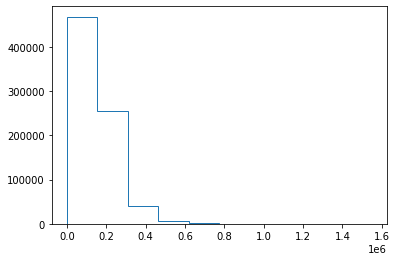

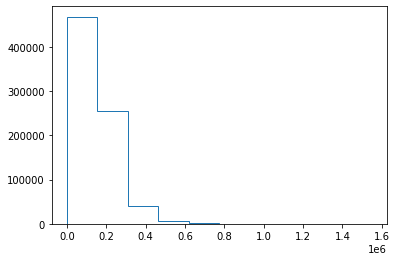

In [16]:
plt.figure('fig1')
plt.hist(truths['th_pt'],histtype='step')
plt.figure('fig2')
plt.hist(dataset['th_pt'],histtype='step')